# HW 2

In [136]:
import numpy as np
import cv2
import glob
import matplotlib as mpl
import matplotlib.pyplot as plt
from PIL import Image
import os

In [137]:
%config InlineBackend.figure_format = "retina"
mpl.rcParams['figure.dpi'] = 100

## Util functions

In [345]:
def visualize_fft_channels(fft_shifted):
    """
    Visualize the magnitude spectrum of the Fourier transform for RGB channels.
    
    Parameters:
    fft_shifted (numpy.ndarray): The shifted Fourier transform of an RGB image.
                                 Shape should be (height, width, 3).
    """
    # Ensure the input is 3D (height, width, 3 channels)
    if len(fft_shifted.shape) != 3 or fft_shifted.shape[2] != 3:
        raise ValueError("Input must be a 3D array with shape (height, width, 3)")

    # Calculate the magnitude spectrum for each channel
    magnitude_spectrum_r = np.log(np.abs(fft_shifted[:,:,0]) + 1)
    magnitude_spectrum_g = np.log(np.abs(fft_shifted[:,:,1]) + 1)
    magnitude_spectrum_b = np.log(np.abs(fft_shifted[:,:,2]) + 1)

    # Create a figure with 4 subplots
    fig, axs = plt.subplots(2, 2, figsize=(16, 16))
    fig.suptitle('Fourier Transform Magnitude Spectrum', fontsize=16)

    # Plot R channel
    axs[0, 0].imshow(magnitude_spectrum_r, cmap='hot')
    axs[0, 0].set_title('Red Channel')
    axs[0, 0].axis('off')

    # Plot G channel
    axs[0, 1].imshow(magnitude_spectrum_g, cmap='hot')
    axs[0, 1].set_title('Green Channel')
    axs[0, 1].axis('off')

    # Plot B channel
    axs[1, 0].imshow(magnitude_spectrum_b, cmap='hot')
    axs[1, 0].set_title('Blue Channel')
    axs[1, 0].axis('off')

    # Plot RGB combined
    rgb_magnitude = np.stack((
        magnitude_spectrum_r / np.max(magnitude_spectrum_r),
        magnitude_spectrum_g / np.max(magnitude_spectrum_g),
        magnitude_spectrum_b / np.max(magnitude_spectrum_b)
    ), axis=2)
    axs[1, 1].imshow(rgb_magnitude)
    axs[1, 1].set_title('RGB Combined')
    axs[1, 1].axis('off')

    plt.tight_layout()
    plt.show()

def display_fft_amplitude(fft_shifted):
    """
    Display the amplitude of the Fourier transform for a single-channel image.
    
    Parameters:
    fft_shifted (numpy.ndarray): The shifted Fourier transform of a grayscale image.
                                 Shape should be (height, width).
    """
    # Ensure the input is 2D (height, width)
    if len(fft_shifted.shape) != 2:
        raise ValueError("Input must be a 2D array with shape (height, width)")

    # Calculate the amplitude spectrum
    amplitude_spectrum = np.abs(fft_shifted)
    
    # Apply log scaling for better visualization
    amplitude_spectrum = np.log1p(amplitude_spectrum)

    # Create a figure
    plt.figure(figsize=(10, 8))
    
    # Display the amplitude spectrum
    plt.imshow(amplitude_spectrum, cmap='viridis')
    plt.colorbar(label='Log Amplitude')
    plt.title('Fourier Transform Amplitude Spectrum')
    plt.axis('off')
    
    plt.tight_layout()
    plt.show()

def plot_images_side_by_side(image1, image2, title1="Image 1", title2="Image 2", figsize=(12, 6)):
    """
    Plot two images side by side using matplotlib.
    
    Parameters:
    image1 (numpy.ndarray): The first image to plot.
    image2 (numpy.ndarray): The second image to plot.
    title1 (str): Title for the first image. Default is "Image 1".
    title2 (str): Title for the second image. Default is "Image 2".
    figsize (tuple): Figure size (width, height) in inches. Default is (12, 6).
    
    Note: This function assumes that both images are either both grayscale or both RGB.
    """
    # Create a figure with two subplots side by side
    fig, (ax1) = plt.subplots(1, 2, figsize=figsize)
    fig.suptitle('Image Comparison', fontsize=16)

    # Plot the first image
    if len(image1.shape) == 2 or image1.shape[2] == 1:  # Grayscale
        im1 = ax1.imshow(image1, cmap='gray')
    else:  # RGB
        im1 = ax1.imshow(image1)
    ax1.set_title(title1)
    ax1.axis('off')

    # Plot the second image
    if len(image2.shape) == 2 or image2.shape[2] == 1:  # Grayscale
        im2 = ax2.imshow(image2, cmap='gray')
    else:  # RGB
        im2 = ax2.imshow(image2)
    ax2.set_title(title2)
    ax2.axis('off')

    # Add colorbars
    fig.colorbar(im1, ax=ax1, fraction=0.046, pad=0.04)
    fig.colorbar(im2, ax=ax2, fraction=0.046, pad=0.04)

    # Adjust the layout and display the plot
    plt.tight_layout()
    plt.show()

# Part 1

## Load data

In [416]:
idx = 2
switch_order = False

In [417]:
images = glob.glob(f'data/task1and2_hybrid_pyramid/{idx}*')
assert len(images) == 2
if not switch_order:
    path_a, path_b = images
else:
    path_b, path_a = images

In [418]:
img_a = Image.open(path_a)
img_b = Image.open(path_b)

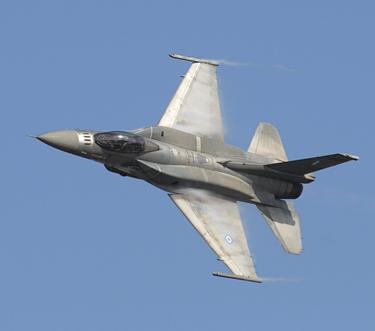

In [419]:
img_a

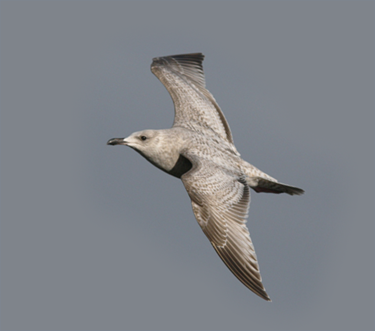

In [420]:
img_b

In [428]:
A = np.array(img_a)
B = np.array(img_b)

width = A.shape[1]
height = A.shape[0]
print(width, height)

375 331


## Conversion into frequency domain

In [430]:
def pos_to_freq(img):
    fft_r = np.fft.fft2(img[:,:,0])
    fft_g = np.fft.fft2(img[:,:,1])
    fft_b = np.fft.fft2(img[:,:,2])
    
    fft_combined = np.stack((fft_r, fft_g, fft_b), axis=2)
    fft_shifted = np.fft.fftshift(fft_combined)
    return fft_shifted

def pos_to_freq_grayscale(img):
    fft = np.fft.fft2(img)
    fft_shifted = np.fft.fftshift(fft)
    return fft_shifted

def freq_to_pos(fft_shifted):
    # Inverse shift
    fft_unshifted = np.fft.ifftshift(fft_shifted)
    
    # Separate channels
    fft_r = fft_unshifted[:,:,0]
    fft_g = fft_unshifted[:,:,1]
    fft_b = fft_unshifted[:,:,2]
    
    # Inverse FFT for each channel
    img_r = np.fft.ifft2(fft_r).real
    img_g = np.fft.ifft2(fft_g).real
    img_b = np.fft.ifft2(fft_b).real
    
    # Stack channels and ensure values are in valid range
    img = np.stack((img_r, img_g, img_b), axis=2)
    img = np.clip(img, 0, 255).astype(np.uint8)
    
    return img

In [431]:
fft_shifted = pos_to_freq(A)

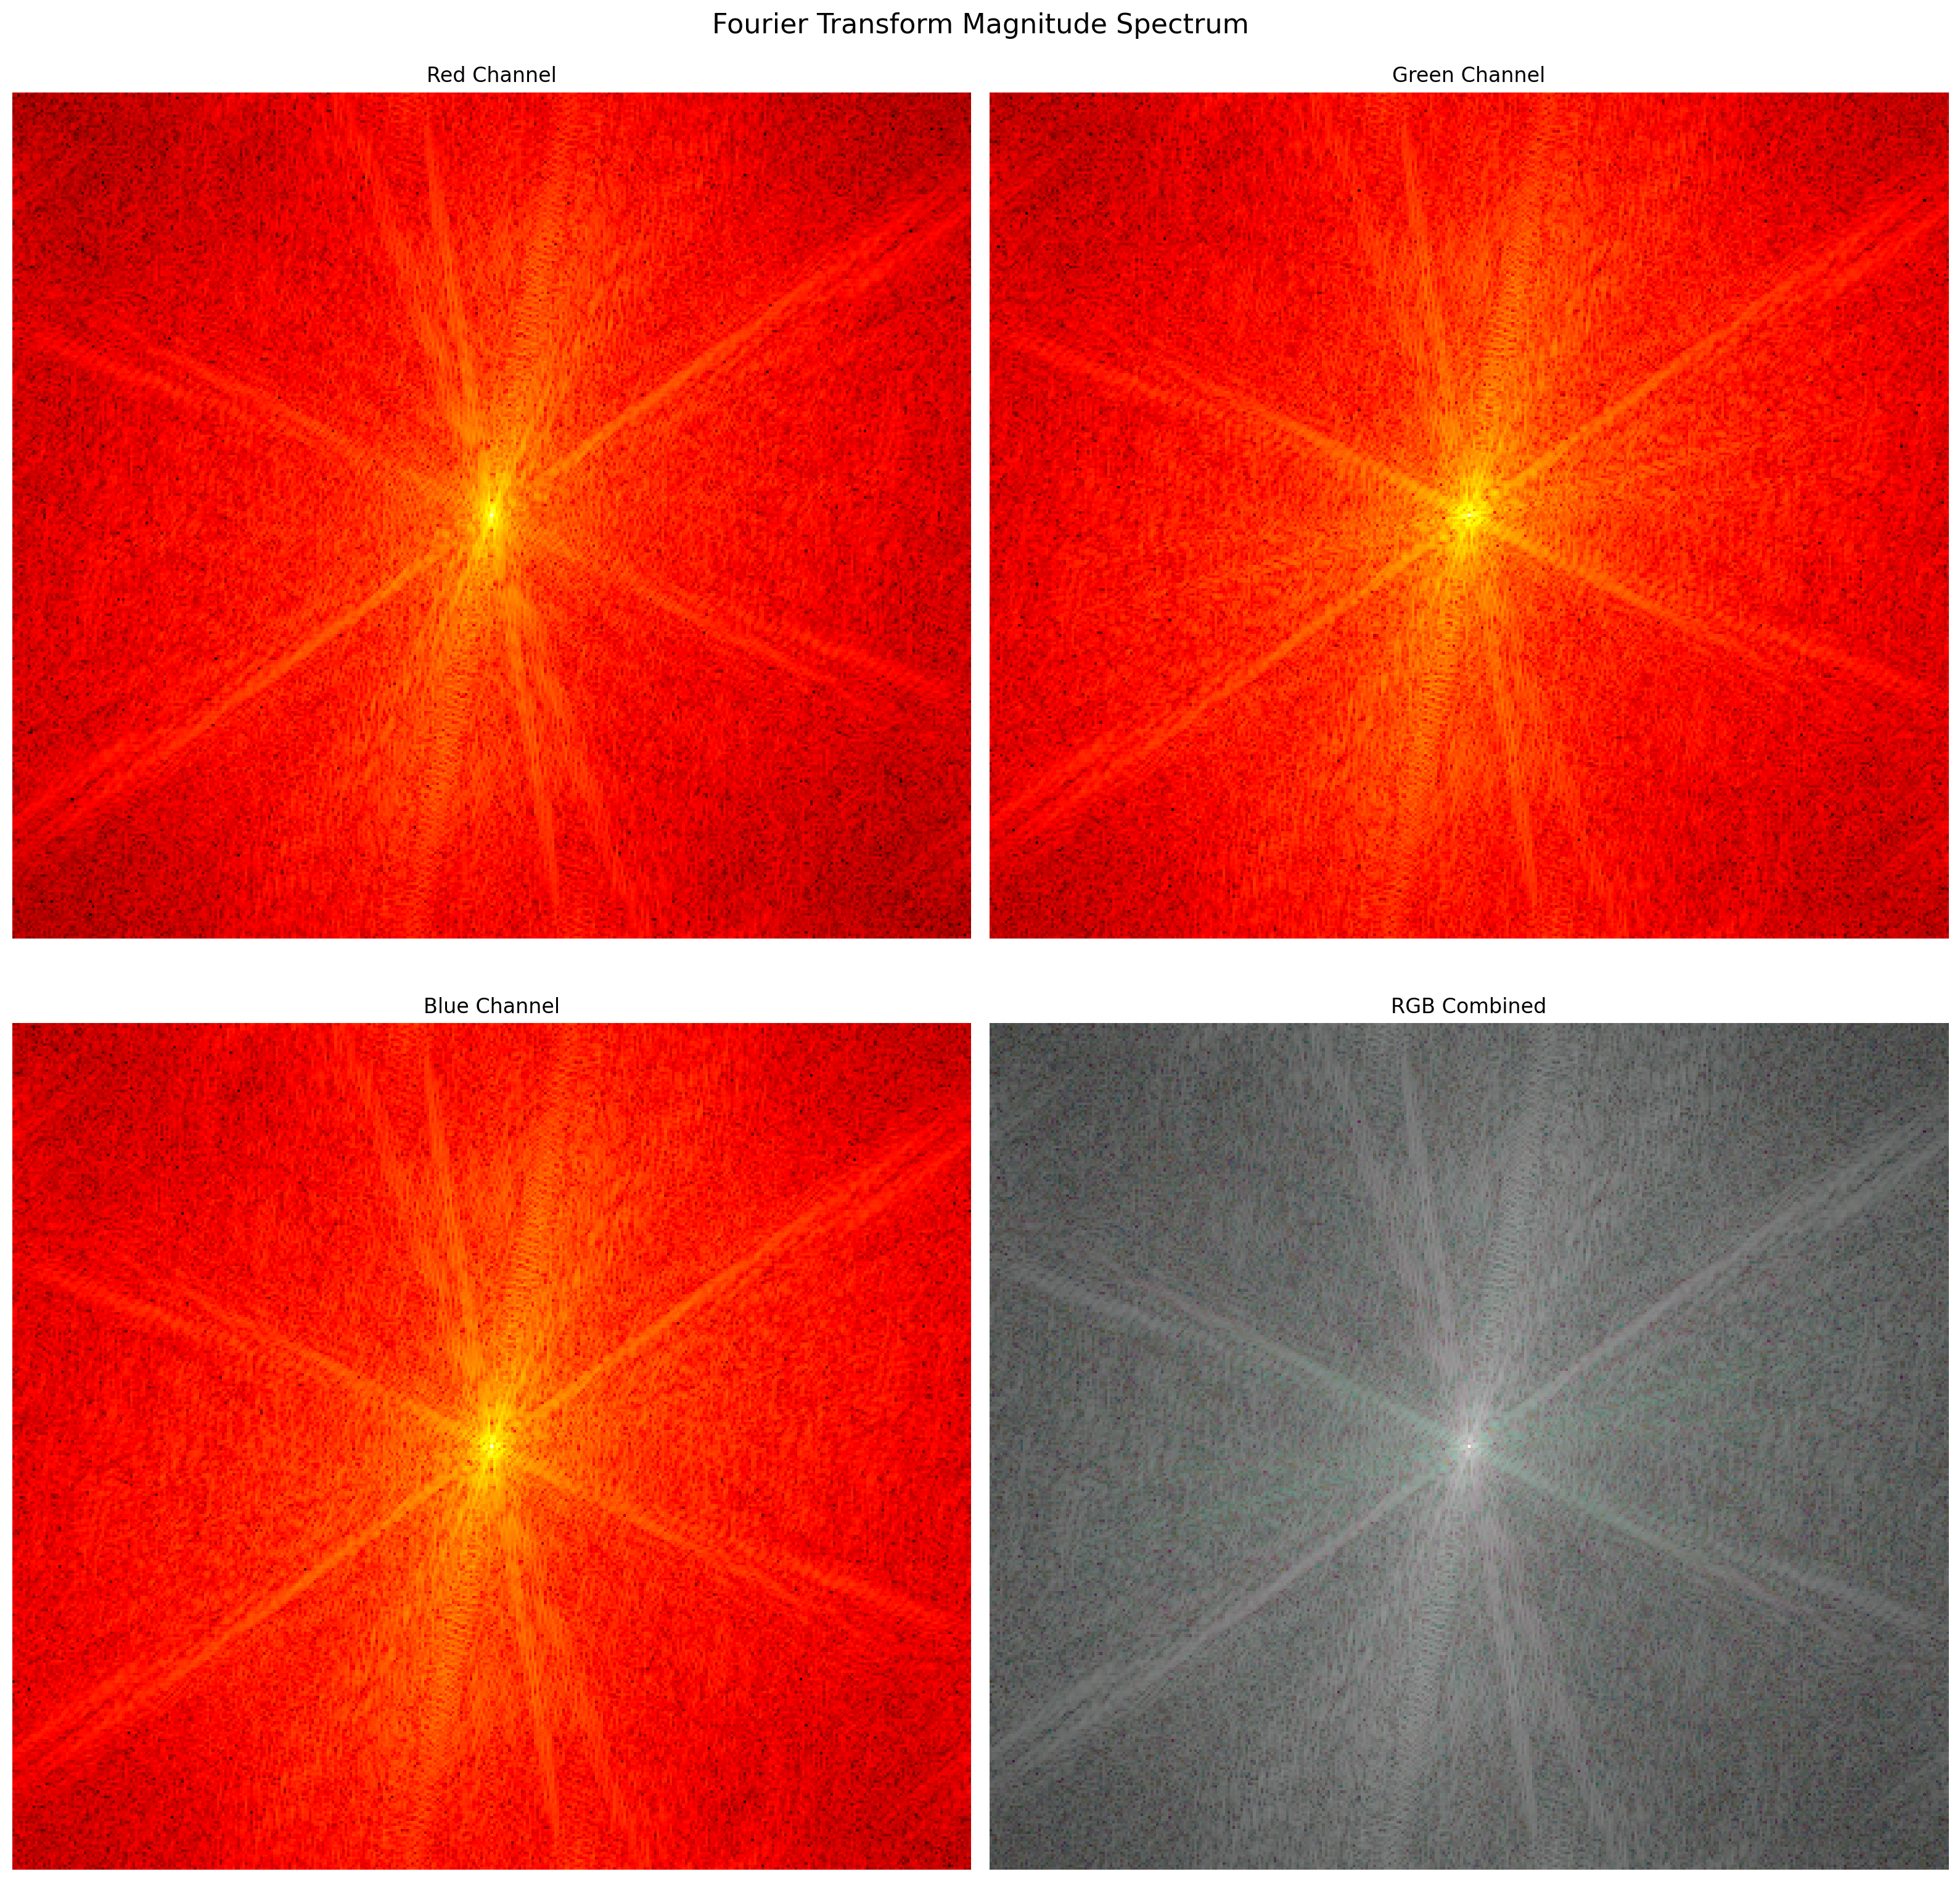

In [432]:
visualize_fft_channels(fft_shifted)

## Gaussian kernel

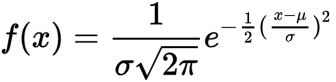


In [433]:
gaussian_high_pass(2,1)

np.float64(0.1353352832366127)

In [434]:
def normal_dist_pdf(x, sigma):
    return 1 / (sigma * np.sqrt(2*np.pi)) \
            * np.exp(-1/2 * (x/sigma)**2) 

def gaussian_high_pass(x,D_0):
    return np.exp(-1 * ((x**2) / 2) * (D_0 ** 2))

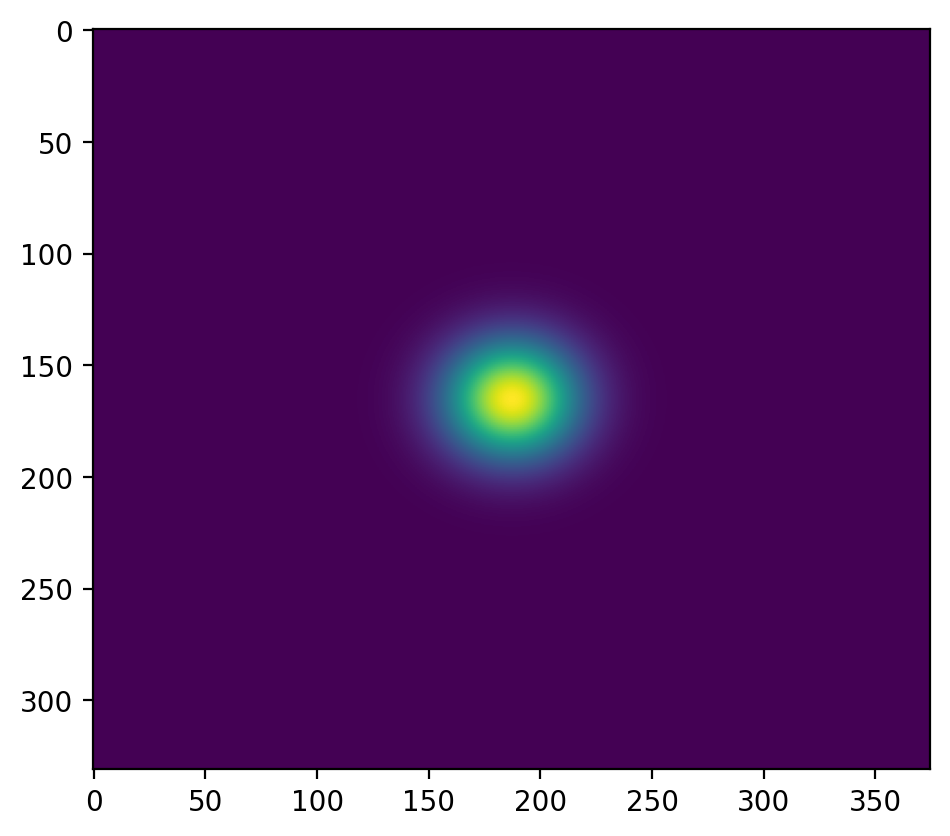

In [473]:
def gaussian_kernel(width, height, sigma):
    x = np.linspace(-1,1, width)
    y = np.linspace(-1,1, height)

    xv, yv = np.meshgrid(x,y)

    xc = (width ) / 2
    yc = (height) / 2

    dist = np.sqrt((xv)**2 + (yv) ** 2)

    kernel = gaussian_high_pass(dist, sigma)

    return kernel


K_low_pass = gaussian_kernel(width,height,9)

plt.imshow(K_low_pass)

#display_fft_amplitude(pos_to_freq_grayscale(K_low_pass))

## Convolution in frequencyfft_shifted domain

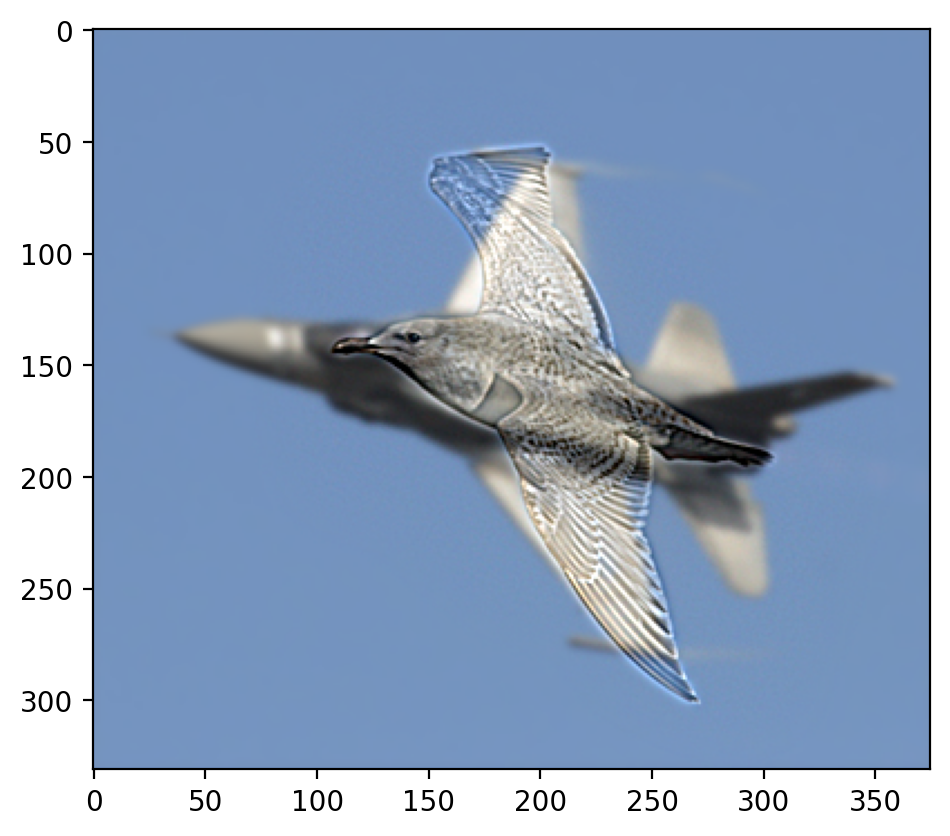

In [471]:
K = gaussian_kernel(width,height,6)

A_low = pos_to_freq(A) * (K)[:, :, np.newaxis]
B_high = pos_to_freq(B) * (1 - K)[:, :, np.newaxis]

plt.imshow(freq_to_pos(1*A_low + 2*B_high))

# Laplacian pyramid